In [119]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

In [120]:
df = pd.read_csv('expansion_analysis_df.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39298 entries, 0 to 39297
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            39298 non-null  object 
 1   group                              39298 non-null  object 
 2   session_count                      39298 non-null  float64
 3   total_usage_seconds                39298 non-null  float64
 4   avg_session_length                 39298 non-null  float64
 5   active_days                        39298 non-null  float64
 6   most_used_device                   15018 non-null  object 
 7   total_events                       39298 non-null  float64
 8   avg_latency                        39298 non-null  float64
 9   error_rate                         39298 non-null  float64
 10  jira_board_event_count             39298 non-null  float64
 11  jira_automation_event_count        39298 non-null  flo

In [150]:
df.groupby('group')[num_cols].describe().T

/tmp/ipykernel_11309/426314924.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('group')[num_cols].describe().T


group                           control     expansion
session_count       count  19649.000000  19649.000000
                    mean       0.966512      0.343733
                    std        1.276869      0.681764
                    min        0.000000      0.000000
                    25%        0.000000      0.000000
...                                 ...           ...
had_overdue_invoice min        0.000000      0.000000
                    25%        0.000000      0.000000
                    50%        0.000000      0.000000
                    75%        0.000000      0.000000
                    max        1.000000      1.000000

[216 rows x 2 columns]

In [121]:
df = df[df['group'].notna()].copy()
df['group'] = df['group'].astype('category')

# Identify numeric columns
num_cols = df.select_dtypes(include='number').columns.tolist()

# Heuristic: binary columns are those with only {0,1} (after dropping NaNs)
def is_binary(series):
    vals = pd.unique(series.dropna())
    return set(vals).issubset({0,1}) and len(vals) <= 2

binary_cols = [c for c in num_cols if is_binary(df[c])]
continuous_cols = [c for c in num_cols if c not in binary_cols]

# Helpful sets for charts
feature_flag_cols = [c for c in binary_cols if c.startswith('used_')]  # used_* flags


In [122]:
df['support_ticket_count'].unique()

array([ 0,  1,  2,  3,  8,  4,  5,  7,  6, 13, 10,  9, 11, 14, 15, 12, 17,
       16, 18, 31, 19, 22, 26, 23, 27, 20, 21, 24, 29, 25, 28, 32, 30, 34,
       33, 38, 37, 39, 35])

<Axes: xlabel='session_count', ylabel='count'>

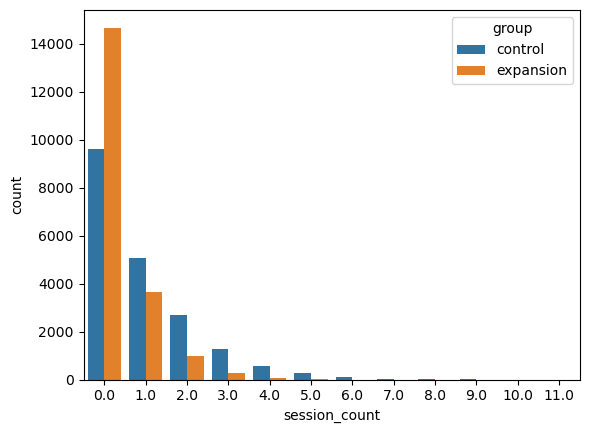

In [145]:
sns.countplot(df,x ='session_count', hue = 'group')

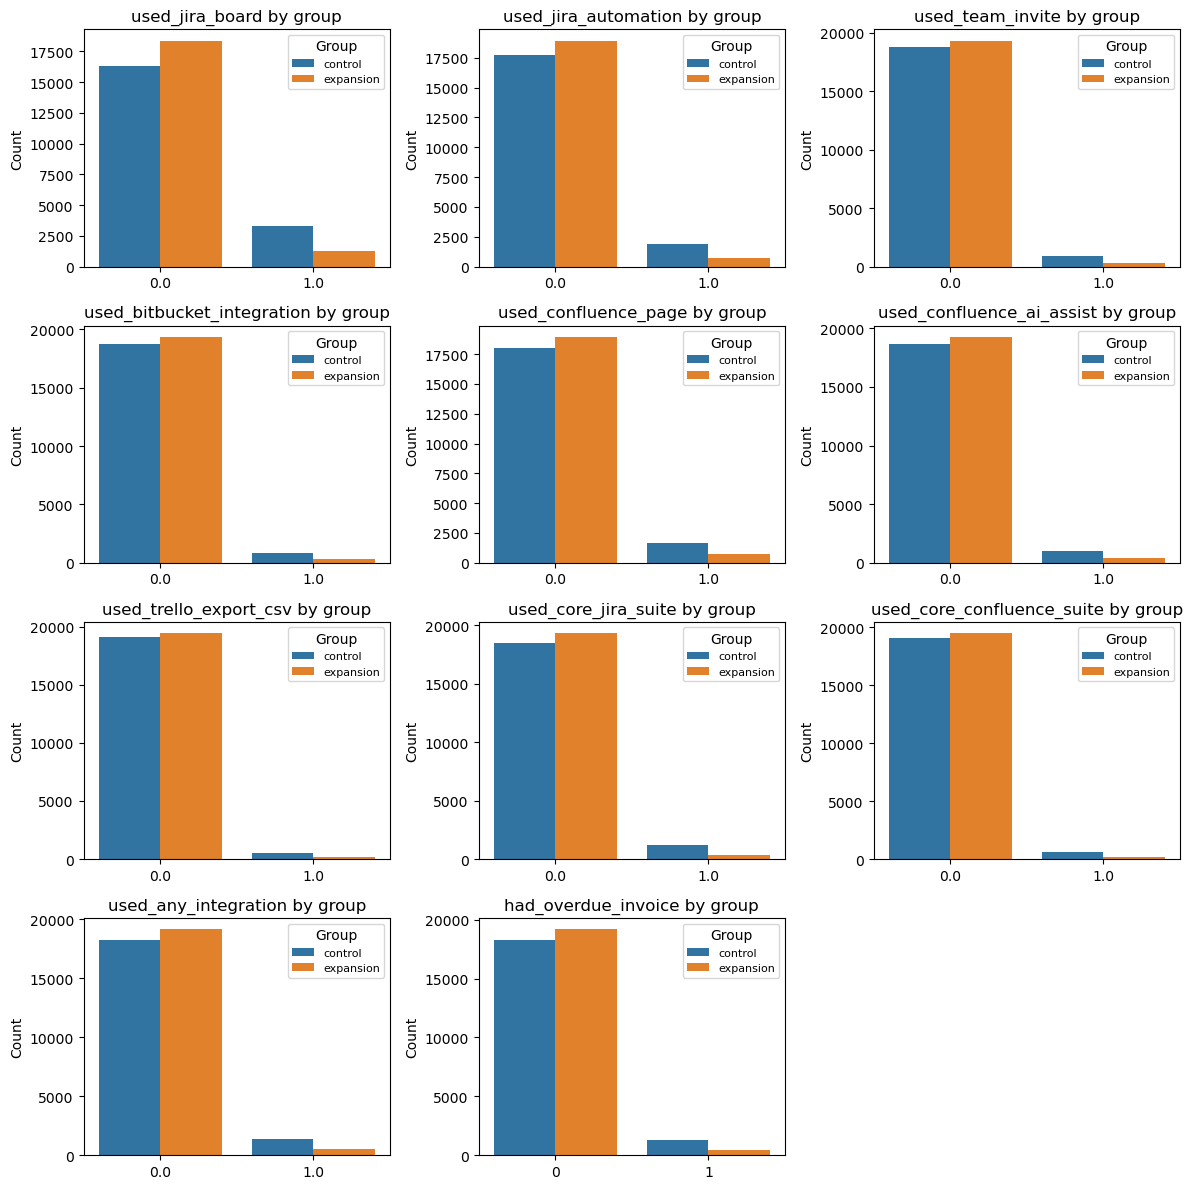

In [124]:
# (optional) fix category order
df['group'] = pd.Categorical(df['group'], ['control', 'expansion'])

n = len(binary_cols)
cols = 3                       # how many charts per row
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), squeeze=False)
axes = axes.ravel()

for ax, col in zip(axes, binary_cols):
    sns.countplot(data=df, x=col, hue='group', ax=ax)
    ax.set_title(f'{col} by group')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.legend(title='Group', fontsize=8)

# turn off any unused axes
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


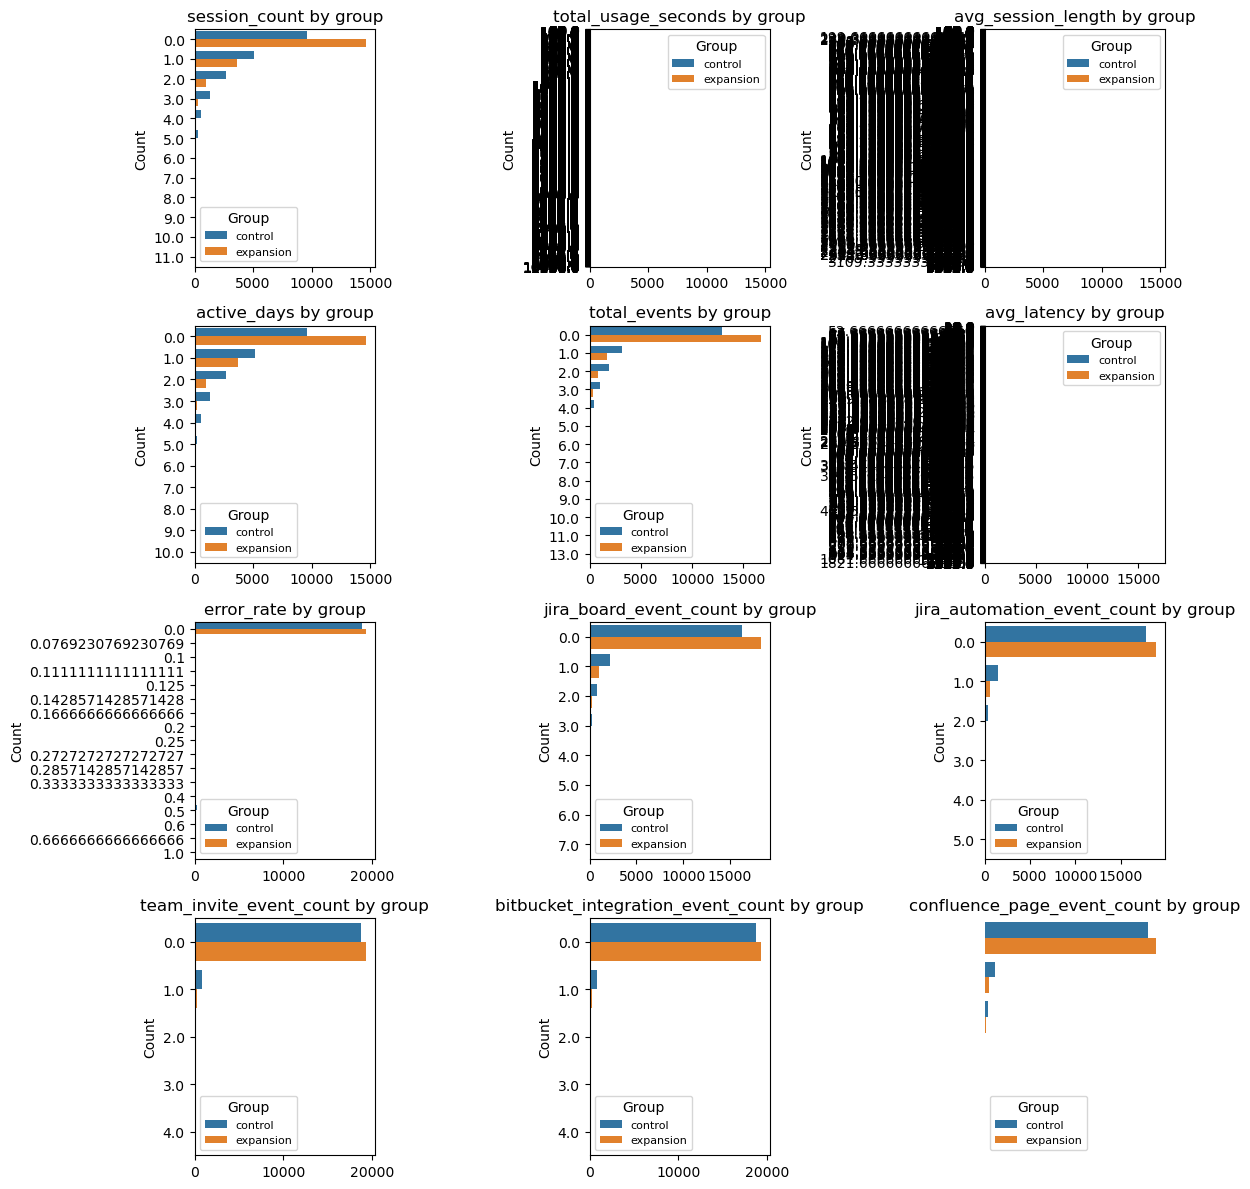

In [147]:
# (optional) fix category order
import math
df['group'] = pd.Categorical(df['group'], ['control', 'expansion'])

n = len(binary_cols)
cols = 3                       # how many charts per row
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), squeeze=False)
axes = axes.ravel()

for ax, col in zip(axes, num_cols):
    sns.countplot(data=df, y=col, hue='group', ax=ax)
    ax.set_title(f'{col} by group')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.legend(title='Group', fontsize=8)

# turn off any unused axes
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [126]:
# Adoption rate between the two groups
feature_flag_cols = [c for c in binary_cols if c.startswith('used_')]

# 2) Make sure they’re clean 0/1 integers
flags = (df[feature_flag_cols]
           .apply(pd.to_numeric, errors='coerce')   # coerce weird entries
           .fillna(0))

flags = (flags > 0).astype('uint8') 

flags = flags.drop(['used_core_jira_suite', 'used_core_confluence_suite',
       'used_any_integration'], axis=1)
n_feats = flags.shape[1]
df['feature_adoption_count'] = flags.sum(axis=1)
df['feature_adoption_count']
df['feature_adoption_rate']  = ( df['feature_adoption_count'] / n_feats)

adoption_by_group = (df
    .groupby('group')
    .agg(
        users=('user_id','count'),
        mean_count=('feature_adoption_count','mean'),
        median_count=('feature_adoption_count','median'),
        mean_rate=('feature_adoption_rate','mean')  # 0–1; multiply by 100 for %
    )
    .reset_index()
)
adoption_by_group


/tmp/ipykernel_11309/2431287749.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('group')


,group,users,mean_count,median_count,mean_rate
0,control,19649,0.518500,0.0,0.074071
1,expansion,19649,0.196855,0.0,0.028122


In [128]:
per_feature_rates = df.groupby('group')[feature_flag_cols].mean().T
per_feature_rates.columns = [f'{g}_rate' for g in per_feature_rates.columns]
per_feature_rates = (per_feature_rates * 100).round(1)  # percentage
per_feature_rates

/tmp/ipykernel_11309/1187442289.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_feature_rates = df.groupby('group')[feature_flag_cols].mean().T


,control_rate,expansion_rate
used_jira_board,16.9,6.5
used_jira_automation,9.8,3.6
used_team_invite,4.5,1.6
used_bitbucket_integration,4.5,1.5
used_confluence_page,8.5,3.6
used_confluence_ai_assist,5.1,1.9
used_trello_export_csv,2.6,1.0
used_core_jira_suite,6.0,1.6
used_core_confluence_suite,2.9,0.9
used_any_integration,7.0,2.5


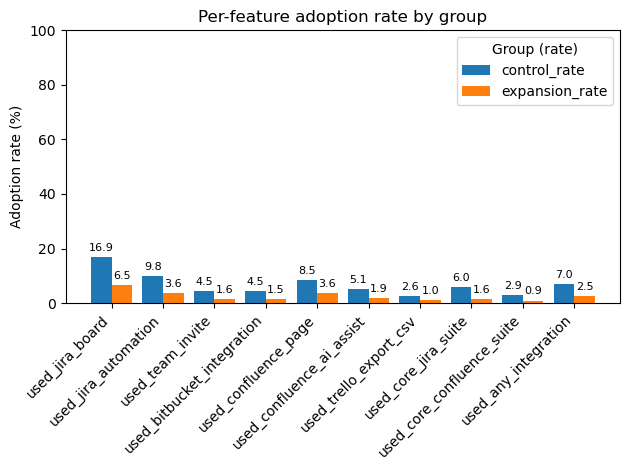

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# per_feature_rates: index = feature names, columns = "<group>_rate" (values in %)
rates_df = per_feature_rates.copy()
rates_df.columns = rates_df.columns.astype(str)  # just in case

x = np.arange(len(rates_df.index))
n = len(rates_df.columns)
w = 0.8 / max(n, 1)

fig = plt.figure()
ax = fig.add_subplot(111)

for i, col in enumerate(rates_df.columns):
    ax.bar(x + (i - (n-1)/2)*w, rates_df[col].values, width=w, label=col)

ax.set_xticks(x)
ax.set_xticklabels(rates_df.index, rotation=45, ha='right')
ax.set_ylabel('Adoption rate (%)')
ax.set_title('Per-feature adoption rate by group')
ax.set_ylim(0, 100)
ax.legend(title='Group (rate)')

# value labels
for container in ax.containers:
    for bar in container:
        h = bar.get_height()
        if np.isfinite(h):
            ax.annotate(f'{h:.1f}', (bar.get_x()+bar.get_width()/2, h),
                        xytext=(0, 3), textcoords='offset points',
                        ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


/tmp/ipykernel_11309/4056207895.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(lift_sorted.index, rotation=45, ha='right')


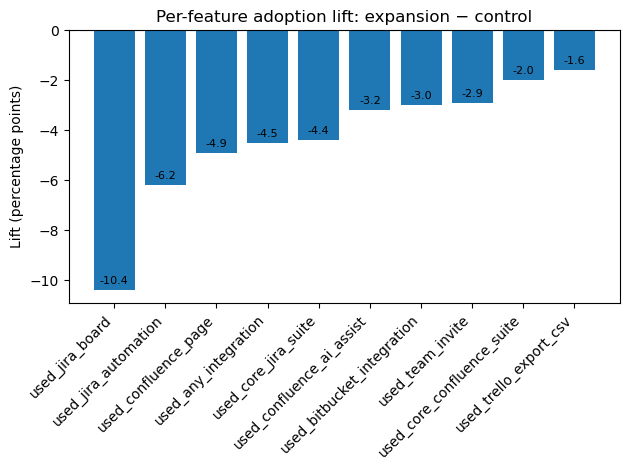

In [131]:
import numpy as np
import matplotlib.pyplot as plt

rates_df = per_feature_rates.copy()

if rates_df.shape[1] == 2:
    cols = list(rates_df.columns)

    # Try to order as control then expansion if available
    if 'control_rate' in cols and 'expansion_rate' in cols:
        g1, g2 = 'control_rate', 'expansion_rate'
    else:
        g1, g2 = cols[0], cols[1]

    lift = (rates_df[g2] - rates_df[g1]).copy()
    lift_sorted = lift.reindex(lift.abs().sort_values(ascending=False).index)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(lift_sorted.index, lift_sorted.values)
    ax.set_xticklabels(lift_sorted.index, rotation=45, ha='right')
    ax.set_ylabel('Lift (percentage points)')
    ax.set_title(f'Per-feature adoption lift: {g2.replace("_rate","")} − {g1.replace("_rate","")}')
    ax.axhline(0, linestyle='--')

    for bar in ax.containers[0]:
        h = bar.get_height()
        if np.isfinite(h):
            ax.annotate(f'{h:.1f}', (bar.get_x()+bar.get_width()/2, h),
                        xytext=(0, 3), textcoords='offset points',
                        ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_11309/595288941.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  derived_rates = (df.groupby('group')[present].mean() * 100).round(1)  # %


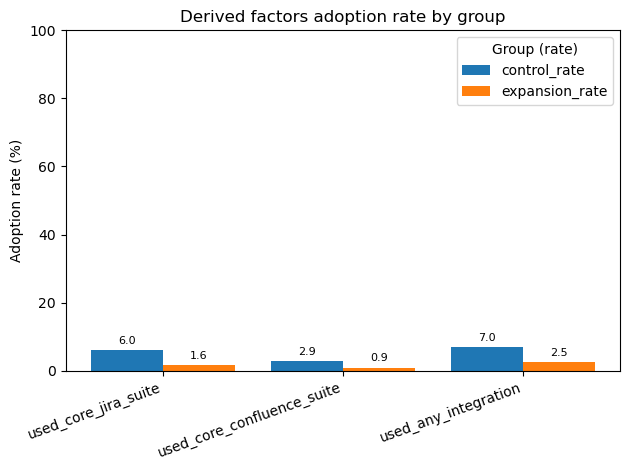

In [132]:
import numpy as np
import matplotlib.pyplot as plt

derived_cols = ['used_core_jira_suite','used_core_confluence_suite','used_any_integration']
present = [c for c in derived_cols if c in df.columns]
if present:
    derived_rates = (df.groupby('group')[present].mean() * 100).round(1)  # %
    plot_df = derived_rates.T
    plot_df.columns = [f'{c}_rate' for c in plot_df.columns]  # match earlier labeling

    x = np.arange(len(plot_df.index))
    n = len(plot_df.columns)
    w = 0.8 / max(n, 1)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i, col in enumerate(plot_df.columns):
        ax.bar(x + (i - (n-1)/2)*w, plot_df[col].values, width=w, label=col)

    ax.set_xticks(x)
    ax.set_xticklabels(plot_df.index, rotation=20, ha='right')
    ax.set_ylabel('Adoption rate (%)')
    ax.set_title('Derived factors adoption rate by group')
    ax.set_ylim(0, 100)
    ax.legend(title='Group (rate)')

    for container in ax.containers:
        for bar in container:
            h = bar.get_height()
            if np.isfinite(h):
                ax.annotate(f'{h:.1f}', (bar.get_x()+bar.get_width()/2, h),
                            xytext=(0, 3), textcoords='offset points',
                            ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()
